# Titanic Data Science Solutions

------------------------------------------------

This notebook is for "Titanic: Machine Learning from Disaster"

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score,roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
matplotlib.style.use('ggplot')

try:
    xrange
except NameError:
    xrange = range

from __future__ import print_function

/Users/tyoshida/.pyenv/versions/3.6.5/envs/machine-learning/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/tyoshida/.pyenv/versions/3.6.5/envs/machine-learning/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## トレーニングデータとテストデータの読み込み

Pandas を用いて、トレーニングデータとテストデータをデータフレームとして読み込む。また、２つのデータセットを合わせたものも用意する。

In [24]:
# Load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
combine = [train_df, test_df]

## データの中身を見る

### どの特徴量がデータセットの中で使用できるか？

In [25]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


### データの中身を見る

それぞれの特徴量が**カテゴリ変数**か**数値変数**かを判断する

#### それぞれの変数の型

Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.

Numerical: Age, Fare. Discrete: SibSp, Parch.

In [26]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### どの特徴量がNULLや空文字（欠損）を含んでいるかを確認する

- トレーニングデータの中では Cabin, Age, Embarked が抜けている
- テストデータの中では Cabin, Age が抜けている

In [22]:
# Check null
print('train_df columns with null values:')
print(train_df.isnull().sum())
print("-"*20)

print('test_df columns with null values:')
print(test_df.isnull().sum())
print("-"*20)

train_df columns with null values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
test_df columns with null values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
--------------------


In [15]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## What is the distribution of numerical feature values across the samples?

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived representative of the actual survival rate at 32%.
- Most passengers (> 75%) did not travel with parents or children.
- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<1%) within age range 65-80.

In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### What is the distribution of categorical features?

- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
- Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [28]:
# show only description of categorical feasures
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Goodwin, Master. Sidney Leonard",male,347082,G6,S
freq,1,577,7,4,644


## データ分析による仮定

### 相関関係

- どの特徴量が **Survived** と相関関係があるかを知る
- 早い段階でこの作業を行い、後でモデル化された相関関係と最初に作成した相関関係を一致させる

### 欠損の補間

- **Age** は明らかに **Survived** との相関関係があるので、補間する
- **Embarked** はおそらく **Survived** とその他の重要な特徴量と相関があるので、補間する

### 変数の修正

- **Ticket** は、891件のデータの対して、ユニーク数が681件になっている。**Ticket** の特徴量は **Survived** 相関がないかもしれないので、おそらく特徴量として落とす
- **Cabin** はほとんど欠損しているので、特徴量として落とす
- **PassengerId** は **Survived** に関係ないので、特徴量として落とす
- **Name** は比較的標準化されてなく、**Survived** に直接的に関係ないかもしれないので、おそらく特徴量として落とす

### 変数の作成

- 家族の数を取得するために、**Parch** と **SibSp** をベースに **Family** という変数を作成する。

### 分類

- 女性 **Sex=Women** はより高い可能性で生き残る
- 子供 **Age<?** はより高い可能性で生き残る
- 高いクラスの乗客 **(Pclass=1)** は、高い可能性で生き残る

## ピボット分析

自分が建てた仮定を確認するために、ピボット分析で素早く特徴量の相関関係を見る。欠損が確認されるデータに対してはこの段階では扱わない。また、カテゴリ (Sex), 順序 (Pclass) 離散 (SibSp, Parch) 変数のみを扱う、


- **Pclass** は強い相関がある (>0.5)。この特徴量をモデルに入れる事にする
- **Sex=female**、女性だと高い確率で生き残る
- **SibSp** と **Parch** は特定の変数とは相関がない。


### 参考

http://mcn-www.jwu.ac.jp/~kuto/kogo_lab/psi-home/stat2000/DATA/09/05.HTM

> | r | =　0.7～1　　　かなり強い相関がある
>
> | r | =　0.4～0.7　　やや相関あり
>
> | r | =　0.2～0.4　　弱い相関あり
>
> | r | =　0～0.2　　　ほとんど相関なし

In [37]:
train_df[['Pclass', 'Survived']] \
 .groupby(['Pclass'], as_index=False) \
 .mean() \
 .sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [39]:
train_df[['Sex', 'Survived']] \
 .groupby(['Sex'], as_index=False) \
 .mean() \
 .sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [40]:
train_df[['SibSp', 'Survived']] \
 .groupby(['SibSp'], as_index=False) \
 .mean() \
 .sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [41]:
train_df[['Parch', 'Survived']] \
 .groupby(['Parch'], as_index=False) \
 .mean() \
 .sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## 可視化によるデータ分析

可視化によるデータ分析で仮定の検証を行う

### 数値変数の相関をみる

ヒストグラムは年齢のような連続的な数値変数を分析するのに役に立つ。特定の年齢バンドが生存に関連があるかを見る。（幼児はより高い確率で生き残るか？）

#### Observations

- 幼児 (Age<=4) は高い確率で生存した
- 最高齢 (Age=80) は生存した
- 15 - 25歳 辺りの大部分は生存しなかった
- 大部分の乗客は15 - 25歳の範囲にいる

#### Decisions.

- Age を訓練モデルに取り入れる
- Age を補間する
- Age をバンドごとに分ける

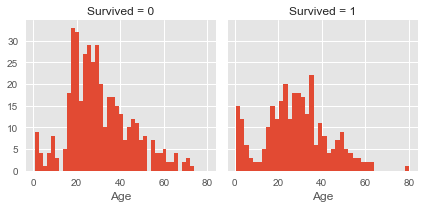

In [46]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=40)

### 順序変数と数値変数の相関

#### Observations

- (Pclass=3) にほとんどの乗客はいる。しかしながら大部分は生存しなかった
- (Pclass=2, Pclass=3) の幼児はほとんど生存した
- (Pclass=1) の乗客は大部分生き残った
- 年齢の分散は **Pclass** によって違う

#### Decisions

- Pclass を訓練モデルに取り入れる

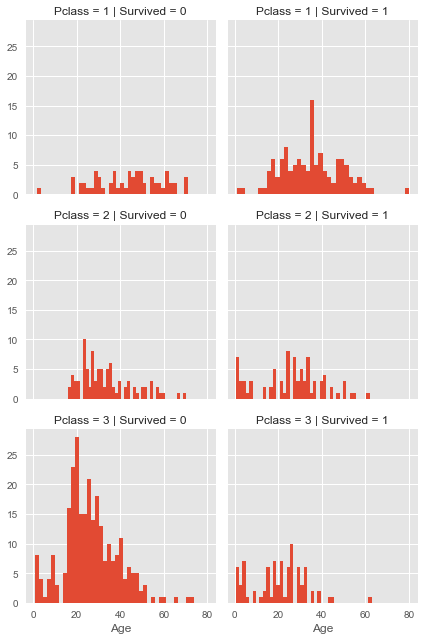

In [54]:
g = sns.FacetGrid(train_df, col='Survived', row='Pclass')
g.map(plt.hist, 'Age', bins=40)

### カテゴリ変数の相関


#### Observations

- 女性の乗客は高い割合で生存する
- (Embarked=C) 例外的に男性が高い割合で生存する。これは Pclass と Embarked に相関があり、次に Pclass と Survived に相関性がある。直接的に Embarked と Survived に相関があるわけではない
- 船出地点 (**Embarked**) で男性とPclass=3の生存率は変わる

#### Decisions

- Sex を訓練モデルに取り入れる
- Embarked を補間し、訓練モデルに取り入れる


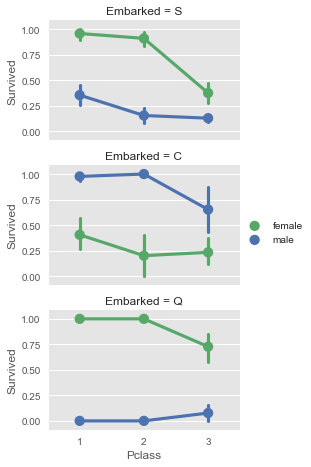

In [56]:
g = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
g.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
g.add_legend()

### カテゴリ変数と数値変数の相関

#### Observations

- (Pclass=3) にほとんどの乗客はいる。しかしながら大部分は生存しなかった
- (Pclass=2, Pclass=3) の幼児はほとんど生存した
- (Pclass=1) の乗客は大部分生き残った
- 年齢の分散は **Pclass** によって違う

#### Decisions

- Pclassモデルに取り入れる

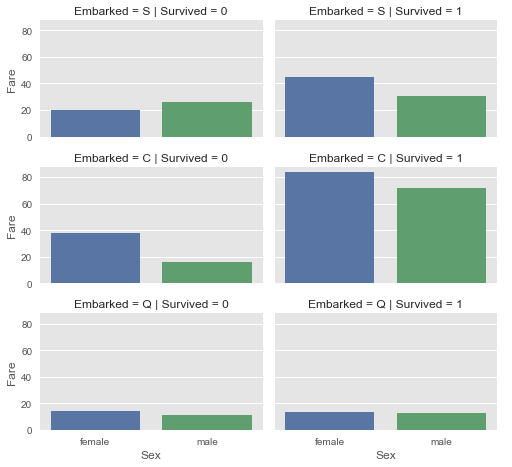

In [66]:
g = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
g.map(sns.barplot, 'Sex', 'Fare', palette='deep', ci=None)
g.add_legend()